## TimingETFs



### Preliminaries

This code builds a sector-rotation strategy based on a momentum signal using ETFs and analyzes its performance.
- We use the data `ETFData.parquet`. 


In [1]:
import qpm
import qpm_download
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.iolib.summary2 import summary_col

Here we specify whether we would like to download the data and the directory in which the data is stored.

In [2]:
import_data = False
_DATA_DIR = '/Users/jiahongcai/Desktop/Quantitative Strategies/Data'

### Step 1. Load Data

We first load the data.

In [3]:
if import_data == True: 
    
    df = qpm_download.etfs('2003-01-01', '2023-07-31')
        
if import_data == False:
    
    # Load the data
    df = pd.read_parquet('%s/ETFdata.parquet' %(_DATA_DIR))

df.head()

,retM,ticker,ym,me,flow,date,retd,mktrf,smb,hml,rf,umd,cpi,inflation,yr5breakeven
0,0.008437,FEF,2003-01-01,5.08000,2.429150e-10,2003-01-02,0.057568,-0.0257,0.007,-0.0083,0.001,0.0155,182.60001,5.280548,1.3
1,-0.020807,IYE,2003-01-01,106.12250,3.695065e-02,2003-01-02,0.027404,-0.0257,0.007,-0.0083,0.001,0.0155,182.60001,5.280548,1.3
2,-0.036869,IYR,2003-01-01,160.06749,-2.723459e-08,2003-01-02,0.000000,-0.0257,0.007,-0.0083,0.001,0.0155,182.60001,5.280548,1.3
3,-0.036904,EWL,2003-01-01,26.75000,2.229281e-09,2003-01-02,0.009901,-0.0257,0.007,-0.0083,0.001,0.0155,182.60001,5.280548,1.3
4,-0.023499,XLU,2003-01-01,642.34503,2.797841e-01,2003-01-02,0.023499,-0.0257,0.007,-0.0083,0.001,0.0155,182.60001,5.280548,1.3


We only need monthly excess returns for the strategy. 
- The first line constructs excess returns. 
- As the data set is daily, the second line converts it to monthly data. 

In [4]:
df['rete'] = df['retM'] - df['rf']
df = df[['ym', 'ticker', 'rete']].drop_duplicates()
df.head()

,ym,ticker,rete
0,2003-01-01,FEF,0.007437
1,2003-01-01,IYE,-0.021807
2,2003-01-01,IYR,-0.037869
3,2003-01-01,EWL,-0.037904
4,2003-01-01,XLU,-0.024499


#### Select Tickers and Signals

Here you can select the tickers you want. 
- For now, we will select five iShares sector ETFs as an example: Financials (IYF), Consumer staples (IYK), Technology (IYW), Telecommunications (IYZ), and Energy (IYE).

We need a weighting scheme to combine these ETFs. We build a simple momentum strategy. 
- The first line creates a column of log returns.
- The second line computes the returns over the last 12 months.
- The last line skips the most recent month. 

In [5]:
df = df[df['ticker'].isin(['SPY', 'BND', 'DBMF', 'CCRV', 'BITO'])].sort_values(['ticker', 'ym'])
df.head()

,ym,ticker,rete
5432070,2021-11-01,BITO,-0.094083
5488653,2021-12-01,BITO,-0.210267
5544456,2022-01-01,BITO,-0.164014
5599737,2022-02-01,BITO,0.091887
5648505,2022-03-01,BITO,0.082538


In [6]:
df['LNrete'] = np.log(1 + df['rete'])
df['mom'] = df.groupby('ticker')['LNrete'].apply(lambda x : x.rolling(12).sum())
df['mom'] = df['mom'] - df['LNrete']
df.head(5)

,ym,ticker,rete,LNrete,mom
5432070,2021-11-01,BITO,-0.094083,-0.098807,NaN
5488653,2021-12-01,BITO,-0.210267,-0.236060,NaN
5544456,2022-01-01,BITO,-0.164014,-0.179143,NaN
5599737,2022-02-01,BITO,0.091887,0.087908,NaN
5648505,2022-03-01,BITO,0.082538,0.079309,NaN


Next, we compute the following weight
$$w_{it} = \frac{\exp(b*mom_{it})}{\sum_j \exp(b*mom_{jt})}. $$

where $b$ is a parameter that is set by the user and $mom_it$ is the value of the momentum signal computed above.
- By taking the exponential, we make sure that the weight remains positive for all ETFs. 
- By dividing by $\sum_j \exp(b*mom_{jt})$, we make sure that the weights add to 1 across all ETFs in that given month.
- The parameter $b$ controls how aggressively we tilt our portfolio. For $b\simeq 0$, we are close to equal weights; for large values of $b$, we pick the ETF with the most favorable momentum signal. This function is sometimes called the *softmax function* (https://en.wikipedia.org/wiki/Softmax_function).

The next block of the code computes the numerator, shifts the signal one period back, and drops observations for which the value of the numerator is not available.

In [7]:
b_param = 10

df['mom'] = np.exp(b_param * df['mom'])
df['Lmom'] = df.groupby(['ticker'])['mom'].shift(1)
df = df.dropna(subset = ['Lmom'])
df = df[df['ym'] >= '2015-01-01']

Next, we compute the denominator and the weights.

In [8]:
df['TLmom'] = df.groupby('ym')['Lmom'].transform('sum')
df['weight'] = df['Lmom'] / df['TLmom']

We are now ready to plot our portfolio weights.

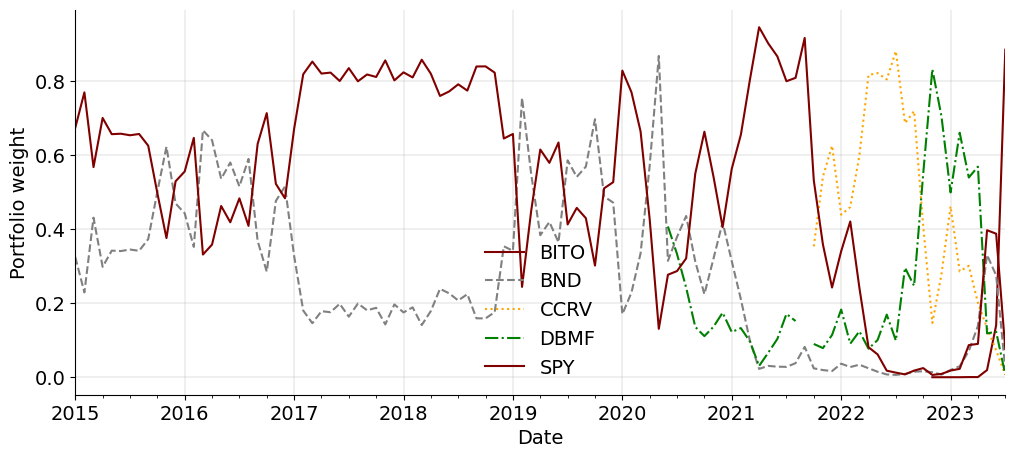

In [9]:
df.sort_values(['ym','ticker'], ascending = [True, True], inplace = True)  

# Plot the portfolio weights 
df.set_index('ym')

plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(1, 1, figsize = (12, 5))
df_pivot = df.pivot(index='ym', columns='ticker', values='weight')
df_pivot.plot(ax = ax)

plt.xlabel('Date')
plt.ylabel('Portfolio weight')
plt.legend()
plt.show()

### Step 2. Portfolio Construction

We now compute the portfolio returns (line 1-4). 
- As a benchmark, we will also compare the performance of this strategy to an equal-weighted strategy (line 5). 
- We also check (line 6) that the weights sum to 1.

In [10]:
df['wgtd_rete'] = df['weight'] * df['rete']

df_rets = {}
df_rets['reteP'] = df.groupby('ym')['wgtd_rete'].sum()
df_rets['reteEW'] = df.groupby('ym')['rete'].mean()
df_rets['reteSPY'] = df[df['ticker'] == 'SPY'].set_index('ym')['rete']
df_rets['check_weights'] = df.groupby('ym')['weight'].sum()
df_rets = pd.DataFrame(df_rets)
print(df_rets.tail(5))

               reteP    reteEW   reteSPY  check_weights
ym                                                     
2023-03-01 -0.041922  0.035756  0.033336            1.0
2023-04-01  0.004190  0.006690  0.012475            1.0
2023-05-01 -0.014909 -0.033267  0.001016            1.0
2023-06-01  0.044725  0.047511  0.060780            1.0
2023-07-01 -0.044889  0.014379  0.028233            1.0


### Step 3. Portfolio Analytics

Regress the returns of the sector-rotation strategy on the equal-weighted average of the ETFs:

In [11]:
results_ETF = smf.ols(formula='reteEW ~ reteSPY', data=df_rets).fit()
print(summary_col(results_ETF,stars=True))


                 reteEW 
------------------------
Intercept      0.0021   
               (0.0013) 
reteSPY        0.4526***
               (0.0280) 
R-squared      0.7215   
R-squared Adj. 0.7187   
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01


Annualized alpha in %:

In [12]:
print(results_ETF.params['Intercept'] * 1200)

2.5038675166134188


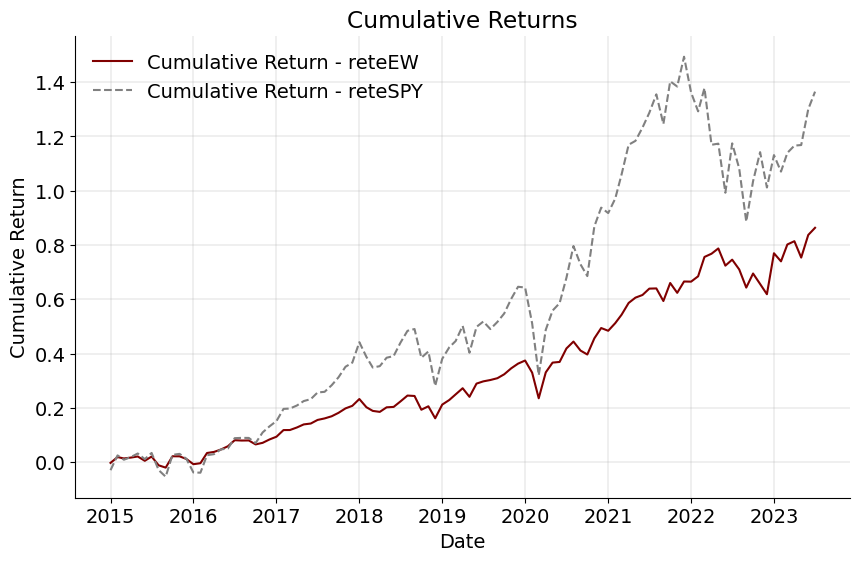

In [13]:
# Assuming df_rets is your DataFrame containing the returns
# Calculate the cumulative returns
cumulative_returns = (1 + df_rets).cumprod() - 1

# Plotting the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns.index, cumulative_returns['reteEW'], label='Cumulative Return - reteEW')
plt.plot(cumulative_returns.index, cumulative_returns['reteSPY'], label='Cumulative Return - reteSPY')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
df = df[df['ticker'].isin(['SPY', 'BND', 'DBMF', 'CCRV', 'BITO'])].sort_values(['ticker', 'ym'])
df.head()

,ym,ticker,rete,LNrete,mom,Lmom,TLmom,weight,wgtd_rete
6124535,2022-11-01,BITO,-0.151667,-0.164482,0.000021,0.000005,14.325414,3.473257e-07,-5.267782e-08
6187825,2022-12-01,BITO,-0.028534,-0.028949,0.000043,0.000021,23.155848,9.055666e-07,-2.583907e-08
6246956,2023-01-01,BITO,0.399185,0.335890,0.000193,0.000043,12.155991,3.528990e-06,1.408718e-06
6307246,2023-02-01,BITO,-0.005500,-0.005515,0.002300,0.000193,8.867538,2.172324e-05,-1.194753e-07
6364049,2023-03-01,BITO,0.215840,0.195435,0.000985,0.002300,5.551710,4.142595e-04,8.941384e-05


In [15]:
# Calculate mean excess return and standard deviation
mean_reteEW = df_rets['reteEW'].mean()  # Mean excess return of reteEW
std_reteEW = df_rets['reteEW'].std()    # Standard deviation of reteEW
mean_reteSPY = df_rets['reteSPY'].mean()  # Mean excess return of reteSPY
std_reteSPY = df_rets['reteSPY'].std()    # Standard deviation of reteSPY

# Assuming risk-free rate is 0 for this example
risk_free_rate = 0

# Calculate Sharpe ratio for reteEW and reteSPY
sharpe_reteEW = (mean_reteEW - risk_free_rate) / std_reteEW
sharpe_reteSPY = (mean_reteSPY - risk_free_rate) / std_reteSPY

print(f"Sharpe Ratio for reteEW: {sharpe_reteEW}")
print(f"Sharpe Ratio for reteSPY: {sharpe_reteSPY}")

Sharpe Ratio for reteEW: 0.2631414505263222
Sharpe Ratio for reteSPY: 0.20794476594463926
